In [105]:


import os, random, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix

# Reproducibility
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Outputs
OUTPUT_DIR = "./icl_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete. tf:", tf.__version__)


Setup complete. tf: 2.20.0


Train images: (60000, 28, 28), Train labels: (60000,)
Test  images: (10000, 28, 28), Test  labels: (10000,)
Train class counts (before imbalance): {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


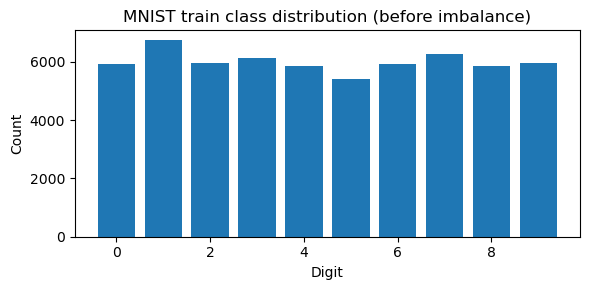

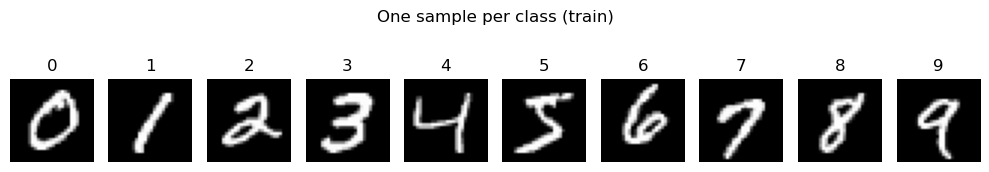

In [106]:
%matplotlib inline

# Load MNIST
(xtr_img, ytr), (xte_img, yte) = tf.keras.datasets.mnist.load_data()

print(f"Train images: {xtr_img.shape}, Train labels: {ytr.shape}")
print(f"Test  images: {xte_img.shape}, Test  labels: {yte.shape}")

# Normalize to [0,1] and flatten (28x28 -> 784) for a simple MLP
xtr = (xtr_img.astype("float32") / 255.0).reshape(-1, 28*28)
xte = (xte_img.astype("float32") / 255.0).reshape(-1, 28*28)

# Class counts BEFORE imbalance
counts_before = np.bincount(ytr, minlength=10)
print("Train class counts (before imbalance):", dict(enumerate(counts_before)))

# Bar plot
plt.figure(figsize=(6,3))
plt.bar(np.arange(10), counts_before)
plt.title("MNIST train class distribution (before imbalance)")
plt.xlabel("Digit"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


plt.figure(figsize=(10,2))
for d in range(10):
    idx = np.where(ytr == d)[0][0]
    plt.subplot(1,10,d+1)
    plt.imshow(xtr_img[idx], cmap="gray"); plt.axis("off"); plt.title(str(d))
plt.suptitle("One sample per class (train)")
plt.tight_layout(); plt.show()


Train class counts (after imbalance): {0: 1184, 1: 6742, 2: 1489, 3: 6131, 4: 1752, 5: 1355, 6: 5918, 7: 1253, 8: 1170, 9: 5949}
Class order (least → most frequent): [8, 0, 7, 5, 2, 4, 6, 9, 3, 1]
Starting with two least frequent classes: [8, 0]


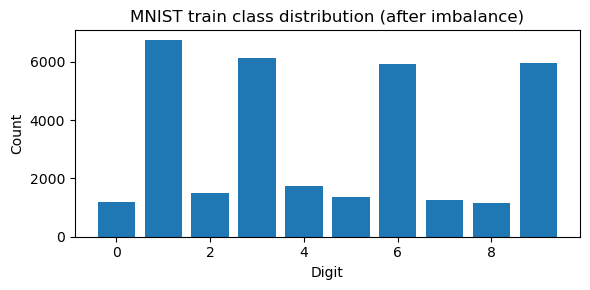

In [107]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


KEEP_FRACTION = {
    0: 0.20, 1: 1.00, 2: 0.25, 3: 1.00, 4: 0.30,
    5: 0.25, 6: 1.00, 7: 0.20, 8: 0.20, 9: 1.00,
}

def make_imbalanced(x, y, keep_fraction_by_class, seed=SEED):
    rng = np.random.default_rng(seed)
    idxs = np.arange(len(y))
    keep = []
    for c in np.unique(y):
        c_idxs = idxs[y == c]
        frac = float(keep_fraction_by_class.get(int(c), 1.0))
        k = max(1, int(len(c_idxs) * frac))
        chosen = rng.choice(c_idxs, size=k, replace=False)
        keep.append(chosen)
    keep = np.concatenate(keep)
    keep.sort()
    return x[keep], y[keep]

# Apply imbalance to TRAIN only
xtr_imb, ytr_imb = make_imbalanced(xtr, ytr, KEEP_FRACTION, seed=SEED)

# Counts AFTER imbalance
counts_after = Counter(ytr_imb.tolist())
print("Train class counts (after imbalance):", dict(sorted(counts_after.items())))

# Minority → majority order (ties broken by class id)
order_least_to_most = sorted(range(10), key=lambda c: (counts_after.get(c, 0), c))
print("Class order (least → most frequent):", order_least_to_most)


start_two = order_least_to_most[:2]
print("Starting with two least frequent classes:", start_two)


plt.figure(figsize=(6,3))
plt.bar(np.arange(10), [counts_after.get(i, 0) for i in range(10)])
plt.title("MNIST train class distribution (after imbalance)")
plt.xlabel("Digit"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


In [108]:
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np


xtr_tr, xtr_val, ytr_tr, ytr_val = train_test_split(
    xtr_imb, ytr_imb, test_size=0.2, random_state=SEED, stratify=ytr_imb
)

print("Train shapes:", xtr_tr.shape, ytr_tr.shape)
print("Valid shapes:", xtr_val.shape, ytr_val.shape)

print("Train counts:", dict(sorted(Counter(ytr_tr.tolist()).items())))
print("Valid counts:", dict(sorted(Counter(ytr_val.tolist()).items())))


Train shapes: (26354, 784) (26354,)
Valid shapes: (6589, 784) (6589,)
Train counts: {0: 947, 1: 5394, 2: 1191, 3: 4905, 4: 1402, 5: 1084, 6: 4734, 7: 1002, 8: 936, 9: 4759}
Valid counts: {0: 237, 1: 1348, 2: 298, 3: 1226, 4: 350, 5: 271, 6: 1184, 7: 251, 8: 234, 9: 1190}


In [109]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import os

INPUT_DIM   = xtr_tr.shape[1]
N_CLASSES   = 10
BASE_HIDDEN = 128
LR          = 1e-3
BATCH_SIZE  = 128
EPOCHS      = 12
PATIENCE    = 3

def build_baseline(input_dim=INPUT_DIM, hidden=BASE_HIDDEN, n_classes=N_CLASSES):
    inp = layers.Input(shape=(input_dim,))
    x   = layers.Dense(hidden, activation="relu", name="hidden")(inp)
    x   = layers.Dropout(0.2)(x)
    out = layers.Dense(n_classes, activation="softmax", name="logits")(x)
    model = models.Model(inp, out, name="baseline_mlp")
    model.compile(optimizer=optimizers.Adam(LR),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

baseline = build_baseline()
es = callbacks.EarlyStopping(monitor="val_accuracy", patience=PATIENCE, restore_best_weights=True)

history = baseline.fit(
    xtr_tr, ytr_tr,
    validation_data=(xtr_val, ytr_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[es]
)


os.makedirs(OUTPUT_DIR, exist_ok=True)
baseline_path = os.path.join(OUTPUT_DIR, "baseline_mlp.keras")
baseline.save(baseline_path)
print("Saved:", baseline_path)


Epoch 1/12
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8572 - loss: 0.5071 - val_accuracy: 0.9270 - val_loss: 0.2435
Epoch 2/12
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9324 - loss: 0.2313 - val_accuracy: 0.9417 - val_loss: 0.1889
Epoch 3/12
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9474 - loss: 0.1801 - val_accuracy: 0.9519 - val_loss: 0.1564
Epoch 4/12
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9563 - loss: 0.1488 - val_accuracy: 0.9592 - val_loss: 0.1368
Epoch 5/12
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9625 - loss: 0.1275 - val_accuracy: 0.9622 - val_loss: 0.1232
Epoch 6/12
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9681 - loss: 0.1094 - val_accuracy: 0.9669 - val_loss: 0.1113
Epoch 7/12
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9720 - loss: 0.0964 - val_accuracy: 0.9689 - val_loss: 0.1052
Epoch 8/12
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9745 - loss: 0.0855 - val_accuracy: 0.

Baseline test accuracy (all classes): 0.9572
Per-class accuracy: {0: 0.9776, 1: 0.9921, 2: 0.9535, 3: 0.9881, 4: 0.947, 5: 0.954, 6: 0.9833, 7: 0.9241, 8: 0.8891, 9: 0.9584}


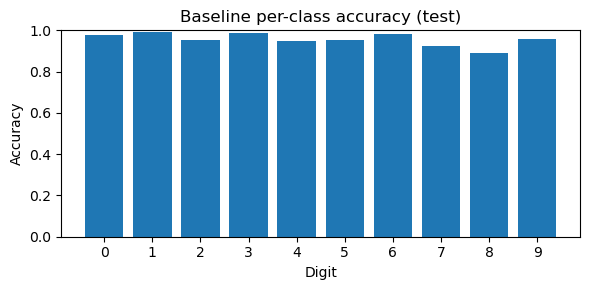

Saved: ./icl_outputs/baseline_per_class_accuracy.png


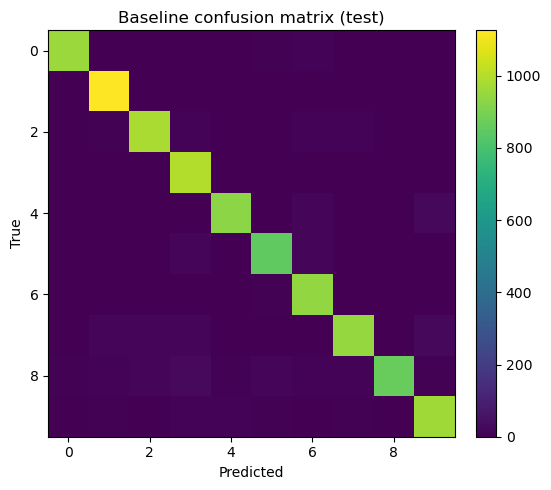

Saved: ./icl_outputs/baseline_confusion_matrix.png


In [110]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# overall test accuracy
y_pred_test = baseline.predict(xte, verbose=0).argmax(axis=1)
acc_test = accuracy_score(yte, y_pred_test)
print(f"Baseline test accuracy (all classes): {acc_test:.4f}")

# per-class accuracy
per_class_acc = {}
for c in range(10):
    mask = (yte == c)
    per_class_acc[c] = accuracy_score(yte[mask], y_pred_test[mask])
print("Per-class accuracy:", {k: round(v,4) for k,v in per_class_acc.items()})

# bar plot of per-class accuracy
plt.figure(figsize=(6,3))
plt.bar(range(10), [per_class_acc[i] for i in range(10)])
plt.xticks(range(10))
plt.ylim(0,1)
plt.title("Baseline per-class accuracy (test)")
plt.xlabel("Digit"); plt.ylabel("Accuracy")
plt.tight_layout()
fig1_path = os.path.join(OUTPUT_DIR, "baseline_per_class_accuracy.png")
plt.savefig(fig1_path, dpi=160); plt.show()
print("Saved:", fig1_path)

# confusion matrix
cm = confusion_matrix(yte, y_pred_test, labels=list(range(10)))
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Baseline confusion matrix (test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
fig2_path = os.path.join(OUTPUT_DIR, "baseline_confusion_matrix.png")
plt.savefig(fig2_path, dpi=160); plt.show()
print("Saved:", fig2_path)


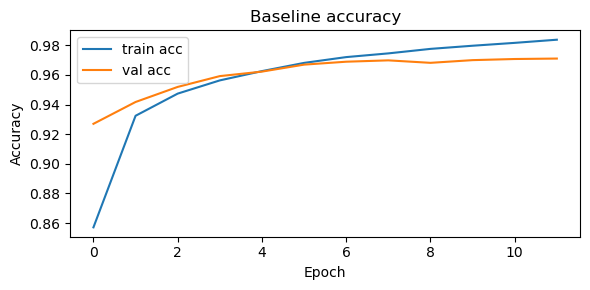

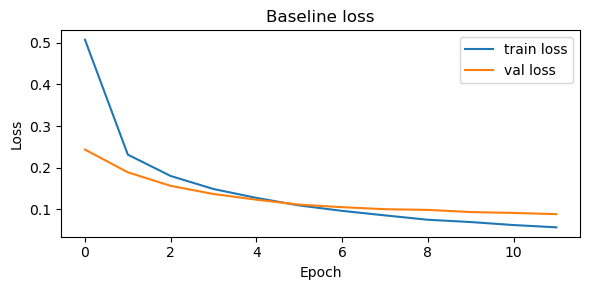

Final generalization gap: 0.0127


In [111]:

plt.figure(figsize=(6,3))
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Baseline accuracy")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Baseline loss")
plt.legend(); plt.tight_layout(); plt.show()

gap = history.history["accuracy"][-1] - history.history["val_accuracy"][-1]
print(f"Final generalization gap: {gap:.4f}")


In [112]:
from tensorflow.keras import layers, models, callbacks, optimizers
import pandas as pd
import numpy as np

def build_mlp(input_dim, hidden, n_classes=10, lr=1e-3):
    inp = layers.Input(shape=(input_dim,))
    h   = layers.Dense(hidden, activation="relu", name="hidden")(inp)
    out = layers.Dense(n_classes, activation="softmax", name="logits")(h)
    m = models.Model(inp, out)
    m.compile(optimizer=optimizers.Adam(lr),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    return m

SIZES    = [16, 32, 64, 128, 256]
EPOCHS   = 12
PATIENCE = 3

rows = []
for hu in SIZES:
    m  = build_mlp(xtr_tr.shape[1], hu)
    es = callbacks.EarlyStopping(monitor="val_accuracy", patience=PATIENCE, restore_best_weights=True)
    h  = m.fit(xtr_tr, ytr_tr,
               validation_data=(xtr_val, ytr_val),
               epochs=EPOCHS, batch_size=128, verbose=0, callbacks=[es])

    train_acc = h.history["accuracy"][-1]
    val_acc   = h.history["val_accuracy"][-1]
    gap       = train_acc - val_acc
    test_acc  = (m.predict(xte, verbose=0).argmax(axis=1) == yte).mean()
    rows.append({"hidden_units": hu,
                 "train_acc": float(train_acc),
                 "val_acc": float(val_acc),
                 "gap": float(gap),
                 "test_acc": float(test_acc)})

sweep_df = pd.DataFrame(rows).sort_values("val_acc", ascending=False)
display(sweep_df)


best_val = sweep_df["val_acc"].max()
epsilon  = 0.002
choice = (sweep_df[sweep_df["val_acc"] >= best_val - epsilon]
          .sort_values("hidden_units")
          .iloc[0])
print("Chosen (parsimony rule):", dict(choice))


,hidden_units,train_acc,val_acc,gap,test_acc
4,256,0.998255,0.972985,0.025269,0.9611
3,128,0.992639,0.969646,0.022992,0.9577
2,64,0.984594,0.962513,0.022081,0.9454
1,32,0.972148,0.955532,0.016616,0.9377
0,16,0.953859,0.940659,0.013200,0.9146


Chosen (parsimony rule): {'hidden_units': 256.0, 'train_acc': 0.9982545375823975, 'val_acc': 0.9729852676391602, 'gap': 0.025269269943237305, 'test_acc': 0.9611}


In [114]:
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# === Simple, explicit criteria ===
ACC_OK_MARGIN   = 0.005   
ACC_MIN_BY_K    = {2: 0.99, 3: 0.985, 4: 0.980, 5: 0.98,
    6: 0.980, 7: 0.98, 8: 0.98, 9: 0.98, 10: 0.98}
MAX_GAP         = 0.01  
PATIENCE        = 3      
EPOCHS          = 12
BATCH           = 128
LR              = 1e-3

def acc_min_for(k):
    return ACC_MIN_BY_K.get(k, 0.92)

def build_model(input_dim, hidden_units, n_classes):
    """hidden_units == 0 → no hidden layer (softmax/logistic regression)."""
    inp = layers.Input(shape=(input_dim,))
    x = inp
    if hidden_units > 0:
        x = layers.Dense(hidden_units, activation="relu", name="hidden")(x)
    out = layers.Dense(n_classes, activation="softmax", name="logits")(x)
    m = models.Model(inp, out)
    m.compile(optimizer=optimizers.Adam(LR),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    return m

def train_once(model, x_tr, y_tr, x_val, y_val):
    es = callbacks.EarlyStopping(monitor="val_accuracy", patience=PATIENCE,
                                 restore_best_weights=True)
    h = model.fit(x_tr, y_tr, validation_data=(x_val, y_val),
                  epochs=EPOCHS, batch_size=BATCH, verbose=0, callbacks=[es])
    tr_acc  = h.history["accuracy"][-1]
    val_acc = h.history["val_accuracy"][-1]
    tr_loss = h.history["loss"][-1]
    val_loss= h.history["val_loss"][-1]
    return dict(train_acc=float(tr_acc), val_acc=float(val_acc),
                train_loss=float(tr_loss), val_loss=float(val_loss),
                epochs_ran=len(h.history["loss"]))

def judge_fit(metrics, k):
    gap = metrics["train_acc"] - metrics["val_acc"]
    underfit = (metrics["val_acc"] < acc_min_for(k)) and (gap < MAX_GAP)
    overfit  = (gap >= MAX_GAP)
    return underfit, overfit, gap

def expand_output_copy_weights(prev_model, input_dim, hidden_units, new_classes):
    """Create a model with same hidden_units but +1 class; copy weights where shapes overlap."""
    old_head = prev_model.get_layer("logits")
    had_hidden = "hidden" in [l.name for l in prev_model.layers]
    new = build_model(input_dim, hidden_units, new_classes)

    if had_hidden and hidden_units > 0:

        W_in_old, b_in_old = prev_model.get_layer("hidden").get_weights()
        W_in_new, b_in_new = new.get_layer("hidden").get_weights()
        W_in_new[:W_in_old.shape[0], :W_in_old.shape[1]] = W_in_old
        b_in_new[:b_in_old.shape[0]] = b_in_old
        new.get_layer("hidden").set_weights([W_in_new, b_in_new])

    
    W_out_old, b_out_old = old_head.get_weights()
    W_out_new, b_out_new = new.get_layer("logits").get_weights()
    W_out_new[:W_out_old.shape[0], :W_out_old.shape[1]] = W_out_old
    b_out_new[:b_out_old.shape[0]] = b_out_old
    new.get_layer("logits").set_weights([W_out_new, b_out_new])
    return new


In [115]:
import numpy as np

def subset_by_classes(x, y, classes):
    """Return only the rows whose labels are in `classes`."""
    mask = np.isin(y, classes)
    return x[mask], y[mask]

def remap(Y, labmap):
    """Map original labels to contiguous indices via labmap."""
    return np.array([labmap[int(c)] for c in Y], dtype=int)

In [116]:
print("Least→most frequent order:", order_least_to_most)
print("Start two:", start_two)


seen = list(start_two)
k = len(seen)

labmap = {c: i for i, c in enumerate(seen)}
invmap = {i: c for c, i in labmap.items()}

def remapY(y, labmap):
    return np.array([labmap[int(c)] for c in y], dtype=int)


x_tr_seen, y_tr_seen_g  = subset_by_classes(xtr_imb, ytr_imb, seen)
x_val_seen, y_val_seen_g = subset_by_classes(xtr_val, ytr_val, seen)


y_tr_seen  = remapY(y_tr_seen_g,  labmap)
y_val_seen = remapY(y_val_seen_g, labmap)

print(f"Step 0 sizes | train: {len(y_tr_seen)}  val: {len(y_val_seen)}")

# Start with 0 hidden neurons (logistic regression)
hidden = 0
model  = build_model(xtr.shape[1], hidden, k)  # k == len(seen)

log_rows = []

while True:
   
    m = train_once(model, x_tr_seen, y_tr_seen, x_val_seen, y_val_seen)

    
    underfit, overfit, gap = judge_fit(m, k)
    target = acc_min_for(k)
    good_enough = (m["val_acc"] >= target) and (gap <= ACC_OK_MARGIN)

  
    print(
        f"[Step0] hidden={hidden} | train_acc={m['train_acc']:.4f} "
        f"val_acc={m['val_acc']:.4f} target={target:.4f} gap={gap:.4f} "
        f"underfit={underfit} overfit={overfit} good_enough={good_enough}"
    )

    if overfit:
        log_rows.append({"hidden": hidden, **m, "gap": float(gap),
                         "underfit": bool(underfit), "overfit": True})
        break

    if underfit:
        
        log_rows.append({"hidden": hidden, **m, "gap": float(gap),
                         "underfit": True, "overfit": False})
        
        hidden += 1
        model = build_model(xtr.shape[1], hidden, k)
        continue

    if good_enough:
   
        log_rows.append({"hidden": hidden, **m, "gap": float(gap),
                         "underfit": False, "overfit": False})
        break

   
    log_rows.append({"hidden": hidden, **m, "gap": float(gap),
                     "underfit": False, "overfit": False})
    break

step0_log = pd.DataFrame(log_rows)
display(step0_log)

Least→most frequent order: [8, 0, 7, 5, 2, 4, 6, 9, 3, 1]
Start two: [8, 0]
Step 0 sizes | train: 2354  val: 471
[Step0] hidden=0 | train_acc=0.9809 val_acc=0.9873 target=0.9900 gap=-0.0064 underfit=True overfit=False good_enough=False
[Step0] hidden=1 | train_acc=0.9834 val_acc=0.9894 target=0.9900 gap=-0.0060 underfit=True overfit=False good_enough=False
[Step0] hidden=2 | train_acc=0.9800 val_acc=0.9873 target=0.9900 gap=-0.0072 underfit=True overfit=False good_enough=False
[Step0] hidden=3 | train_acc=0.9894 val_acc=0.9936 target=0.9900 gap=-0.0043 underfit=False overfit=False good_enough=True


,hidden,train_acc,val_acc,train_loss,val_loss,epochs_ran,gap,underfit,overfit
0,0,0.980884,0.987261,0.067838,0.052462,12,-0.006378,True,False
1,1,0.983432,0.989384,0.279801,0.266434,12,-0.005952,True,False
2,2,0.980034,0.987261,0.277107,0.264042,12,-0.007227,True,False
3,3,0.989380,0.993631,0.042305,0.026575,12,-0.004251,False,False


In [117]:
import pandas as pd, os
EPS = 1e-8  # to avoid float ties at thresholds

history_rows = []

while len(seen) < 10:
    remaining = [c for c in order_least_to_most if c not in seen]
    next_cls  = remaining[0]
    print(f"\n==== Adding class: {next_cls} ====")
    seen.append(next_cls)
    k_now = len(seen)

    labmap = {c:i for i,c in enumerate(seen)}
    invmap = {i:c for c,i in labmap.items()}

   
    x_tr_seen,  y_tr_seen_g  = subset_by_classes(xtr_imb, ytr_imb, seen)
    x_val_seen, y_val_seen_g = subset_by_classes(xtr_val, ytr_val, seen)
    y_tr_seen  = remap(y_tr_seen_g,  labmap)
    y_val_seen = remap(y_val_seen_g, labmap)

   
    model = expand_output_copy_weights(model, xtr.shape[1], hidden, k_now)

 
    step_rows = []
    while True:
        m = train_once(model, x_tr_seen, y_tr_seen, x_val_seen, y_val_seen)

       
        gap    = m["train_acc"] - m["val_acc"]
        target = acc_min_for(k_now)

       
        underfit, overfit, _ = judge_fit(m, k_now)

       
        good_enough = (m["val_acc"] >= target - EPS) and (gap <= ACC_OK_MARGIN + EPS)

        print(f"[k={k_now}] hidden={hidden} | train_acc={m['train_acc']:.4f} "
              f"val_acc={m['val_acc']:.4f} target={target:.4f} gap={gap:.4f} "
              f"underfit={underfit} overfit={overfit} good_enough={good_enough}")

        # ---- decision order: overfit → underfit → good_enough → accept ----
        if overfit:
            step_rows.append({
                "k_seen": k_now, "added_class": next_cls, "hidden": hidden,
                **m, "gap": float(gap), "underfit": bool(underfit), "overfit": True,
                "decision": "stop_overfit"
            })
            break

        if underfit:
            step_rows.append({
                "k_seen": k_now, "added_class": next_cls, "hidden": hidden,
                **m, "gap": float(gap), "underfit": True, "overfit": False,
                "decision": "grow_hidden"
            })
            hidden += 1
            model = build_model(xtr.shape[1], hidden, k_now) 
            continue  

        if good_enough:
            step_rows.append({
                "k_seen": k_now, "added_class": next_cls, "hidden": hidden,
                **m, "gap": float(gap), "underfit": False, "overfit": False,
                "decision": "accept_good_enough"
            })
            break

        # stagnation case: neither under/overfit nor good-enough
        step_rows.append({
            "k_seen": k_now, "added_class": next_cls, "hidden": hidden,
            **m, "gap": float(gap), "underfit": False, "overfit": False,
            "decision": "accept_stagnation"
        })
        break

    history_rows.extend(step_rows)

icl_log = pd.DataFrame(history_rows)
display(icl_log.tail())

os.makedirs(OUTPUT_DIR, exist_ok=True)
icl_csv = os.path.join(OUTPUT_DIR, "icl_incremental_log.csv")
icl_log.to_csv(icl_csv, index=False)
print("Saved:", icl_csv)

final_path = os.path.join(OUTPUT_DIR, f"icl_final_k{len(seen)}_hidden{hidden}.keras")
model.save(final_path)
print("Saved model:", final_path)



==== Adding class: 7 ====
[k=3] hidden=3 | train_acc=0.9814 val_acc=0.9792 target=0.9850 gap=0.0022 underfit=True overfit=False good_enough=False
[k=3] hidden=4 | train_acc=0.9811 val_acc=0.9848 target=0.9850 gap=-0.0036 underfit=True overfit=False good_enough=False
[k=3] hidden=5 | train_acc=0.9872 val_acc=0.9945 target=0.9850 gap=-0.0072 underfit=False overfit=False good_enough=True

==== Adding class: 5 ====
[k=4] hidden=5 | train_acc=0.9557 val_acc=0.9637 target=0.9800 gap=-0.0081 underfit=True overfit=False good_enough=False
[k=4] hidden=6 | train_acc=0.9617 val_acc=0.9688 target=0.9800 gap=-0.0071 underfit=True overfit=False good_enough=False
[k=4] hidden=7 | train_acc=0.9635 val_acc=0.9708 target=0.9800 gap=-0.0073 underfit=True overfit=False good_enough=False
[k=4] hidden=8 | train_acc=0.9704 val_acc=0.9768 target=0.9800 gap=-0.0065 underfit=True overfit=False good_enough=False
[k=4] hidden=9 | train_acc=0.9712 val_acc=0.9799 target=0.9800 gap=-0.0087 underfit=True overfit=Fal

,k_seen,added_class,hidden,train_acc,val_acc,train_loss,val_loss,epochs_ran,gap,underfit,overfit,decision
34,8,9,32,0.973941,0.975592,0.091338,0.077231,12,-0.001650,True,False,grow_hidden
35,8,9,33,0.975835,0.979577,0.087140,0.075934,12,-0.003742,True,False,grow_hidden
36,8,9,34,0.976333,0.980324,0.085011,0.070202,12,-0.003991,False,False,accept_good_enough
37,9,3,34,0.981222,0.985690,0.067048,0.055925,12,-0.004468,False,False,accept_good_enough
38,10,1,34,0.990984,0.990135,0.038242,0.036430,12,0.000849,False,False,accept_good_enough


Saved: ./icl_outputs/icl_incremental_log.csv
Saved model: ./icl_outputs/icl_final_k10_hidden34.keras


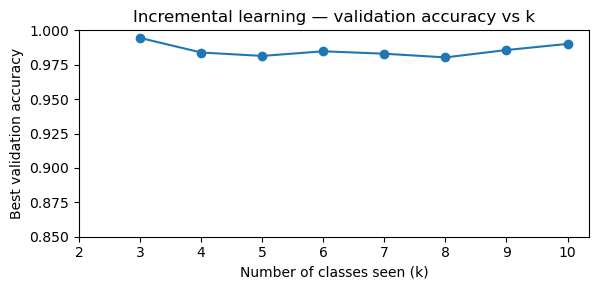

Saved: ./icl_outputs/icl_val_acc_vs_k.png
Final test accuracy on all 10 classes: 0.9377


In [120]:
import matplotlib.pyplot as plt
import numpy as np
import os


if len(icl_log) > 0:
    agg = icl_log.groupby("k_seen")["val_acc"].max().reset_index()
    plt.figure(figsize=(6,3))
    plt.plot(agg["k_seen"], agg["val_acc"], marker="o")
    plt.xticks(range(2, 11))
    plt.ylim(0.85, 1.0)
    plt.xlabel("Number of classes seen (k)")
    plt.ylabel("Best validation accuracy")
    plt.title("Incremental learning — validation accuracy vs k")
    plt.tight_layout()
    fig_path = os.path.join(OUTPUT_DIR, "icl_val_acc_vs_k.png")
    plt.savefig(fig_path, dpi=160); plt.show()
    print("Saved:", fig_path)

final_invmap = {i: c for i, c in enumerate(seen)} 


y_pred_idx  = model.predict(xte, verbose=0).argmax(axis=1)
y_pred_lbl  = np.array([final_invmap[i] for i in y_pred_idx], dtype=int)


full_test_acc = (y_pred_lbl == yte).mean()
print(f"Final test accuracy on all 10 classes: {full_test_acc:.4f}")


In [119]:
import pandas as pd
from pathlib import Path

log_path = Path("./icl_outputs/icl_incremental_log.csv")
icl = pd.read_csv(log_path)


summary = (
    icl.sort_values(["k_seen","val_acc"], ascending=[True,False])
       .groupby("k_seen", as_index=False)
       .first()[["k_seen","added_class","hidden","train_acc","val_acc","gap","underfit","overfit","epochs_ran"]]
)
summary.rename(columns={
    "k_seen":"k (classes seen)",
    "added_class":"new class",
    "hidden":"hidden units",
    "train_acc":"train acc",
    "val_acc":"val acc",
    "gap":"gap (train-val)",
    "epochs_ran":"epochs"
}, inplace=True)

display(summary)

out_csv = Path("./icl_outputs/icl_summary_per_k.csv")
summary.to_csv(out_csv, index=False)
print("Saved:", out_csv)


,k (classes seen),new class,hidden units,train acc,val acc,gap (train-val),underfit,overfit,epochs
0,3,7,5,0.987247,0.994460,-0.007213,False,False,12
1,4,5,10,0.972189,0.983887,-0.011699,False,False,12
2,5,2,16,0.968222,0.981410,-0.013188,False,False,12
3,6,4,16,0.980617,0.984765,-0.004149,False,False,12
4,7,6,16,0.982437,0.983009,-0.000571,False,False,12
5,8,9,34,0.976333,0.980324,-0.003991,False,False,12
6,9,3,34,0.981222,0.985690,-0.004468,False,False,12
7,10,1,34,0.990984,0.990135,0.000849,False,False,12


Saved: icl_outputs/icl_summary_per_k.csv
